In [1]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from google.colab import files

# Load Dataset

In [2]:
uploaded = files.upload()

# Load the dataset
data = pd.read_csv(next(iter(uploaded.keys())))

Saving T.csv to T.csv


# Mean-Variance Utility Function

In [3]:
# Mean-Variance Utility Function
def mean_variance_utility(params, risk_gain, risk_prob, sure_gain, chosen):
    alpha, beta = params
    E_X = risk_prob * risk_gain
    V_X = risk_gain**2 * risk_prob * (1 - risk_prob)
    U_gamble = E_X + alpha * V_X
    U_sure = sure_gain
    logit = beta * (U_gamble - U_sure)
    prob = 1 / (1 + np.exp(-logit))
    log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
    return -np.sum(log_likelihood)

# Exponential Utility Function

In [4]:
# Exponential Utility Function
def exponential_utility(params, risk_gain, risk_prob, sure_gain, chosen):
    rho, beta2 = params
    U_gamble = risk_prob * (risk_gain**rho)
    U_sure = sure_gain**rho
    logit = U_gamble - U_sure
    prob = 1 / (1 + np.exp(-logit / beta2))
    prob = np.clip(prob, 1e-13, 1 - 1e-13)

    log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
    return -np.sum(log_likelihood)

# Prepare Data

In [5]:
# Data Preparation: Filter and Group by Participant
# As the session 5 does not exist, I used session 6 instead
data_filtered = data[data["session"].isin([1, 3, 6])]
data_grouped = data_filtered.groupby("participant")
participant_data = {}

for participant, data_part in data_grouped:
    sessions = {}
    for s in [1, 3, 6]:
        session_data = data_part[data_part["session"] == s]
        session_list = session_data[
            ["observee", "sure_gain", "risk_gain", "risk_prob", "chosen"]
        ].values
        sessions[s] = session_list
    participant_data[participant] = sessions


# Fit both of the utility functions on each participant

In [6]:
# Store results for each participant and each session
results = {}

# Loop through each participant's data and fit the utility functions
for participant, sessions in participant_data.items():
    results[participant] = {}
    for session, session_data in sessions.items():
        sure_gain = session_data[:, 1].astype(float)
        risk_gain = session_data[:, 2].astype(float)
        risk_prob = session_data[:, 3].astype(float)
        chosen = session_data[:, 4].astype(int)

        # Fit Mean-Variance Utility Function
        initial_params_mv = [0, 1]
        result_mv = minimize(
            mean_variance_utility,
            initial_params_mv,
            args=(risk_gain, risk_prob, sure_gain, chosen),
            method="BFGS",
        )
        alpha_mv, beta_mv = result_mv.x

        # Fit Exponential Utility Function
        initial_params_exp = [1, 1]
        result_exp = minimize(
            exponential_utility,
            initial_params_exp,
            args=(risk_gain, risk_prob, sure_gain, chosen),
            method="BFGS",
        )
        rho_exp, beta_exp = result_exp.x

        # Store the results for this participant and session
        results[participant][session] = {
            "Mean-Variance": {"alpha": alpha_mv, "beta": beta_mv},
            "Exponential": {"rho": rho_exp, "beta": beta_exp},
        }

<ipython-input-3-d8069b73868d>:10: RuntimeWarning: divide by zero encountered in log
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868d>:10: RuntimeWarning: invalid value encountered in multiply
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868d>:10: RuntimeWarning: divide by zero encountered in log
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868d>:10: RuntimeWarning: invalid value encountered in multiply
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868d>:10: RuntimeWarning: divide by zero encountered in log
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868d>:10: RuntimeWarning: invalid value encountered in multiply
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868

# Parameters of both of the utility functions on all participants

In [7]:
# Output the results for all participants and sessions
for participant, session_results in results.items():
    for session, res in session_results.items():
        print(f"Participant {participant}, Session {session}:")
        print(
            f"  Mean-Variance Utility Function: alpha = {res['Mean-Variance']['alpha']:.4f}, beta = {res['Mean-Variance']['beta']:.4f}"
        )
        print(
            f"  Exponential Utility Function: rho = {np.log(res['Exponential']['rho']):.4f}, beta = {res['Exponential']['beta']:.4f}"
        )
        print("-----------------------------------------------------")

Participant 65, Session 1:
  Mean-Variance Utility Function: alpha = -0.0243, beta = 0.7798
  Exponential Utility Function: rho = -0.4667, beta = 0.3037
-----------------------------------------------------
Participant 65, Session 3:
  Mean-Variance Utility Function: alpha = 1021.0547, beta = 165.6200
  Exponential Utility Function: rho = -0.0046, beta = 0.6702
-----------------------------------------------------
Participant 65, Session 6:
  Mean-Variance Utility Function: alpha = -0.0086, beta = 0.8485
  Exponential Utility Function: rho = -0.1656, beta = 0.6849
-----------------------------------------------------
Participant 66, Session 1:
  Mean-Variance Utility Function: alpha = 0.0000, beta = 1.0000
  Exponential Utility Function: rho = 0.0521, beta = 2.4683
-----------------------------------------------------
Participant 66, Session 3:
  Mean-Variance Utility Function: alpha = 1034.0854, beta = -16.8839
  Exponential Utility Function: rho = 0.0151, beta = 1.1284
--------------

<ipython-input-7-247d476d9629>:23: RuntimeWarning: invalid value encountered in log
  f"  Exponential Utility Function: rho = {np.log(res['Exponential']['rho']):.4f}, beta = {res['Exponential']['beta']:.4f}"


# Plots

<ipython-input-8-fad73f455257>:10: RuntimeWarning: invalid value encountered in log
  rhos = [np.log(results[p][session]["Exponential"]["rho"]) if session in results[p] else 0 for p in participants]


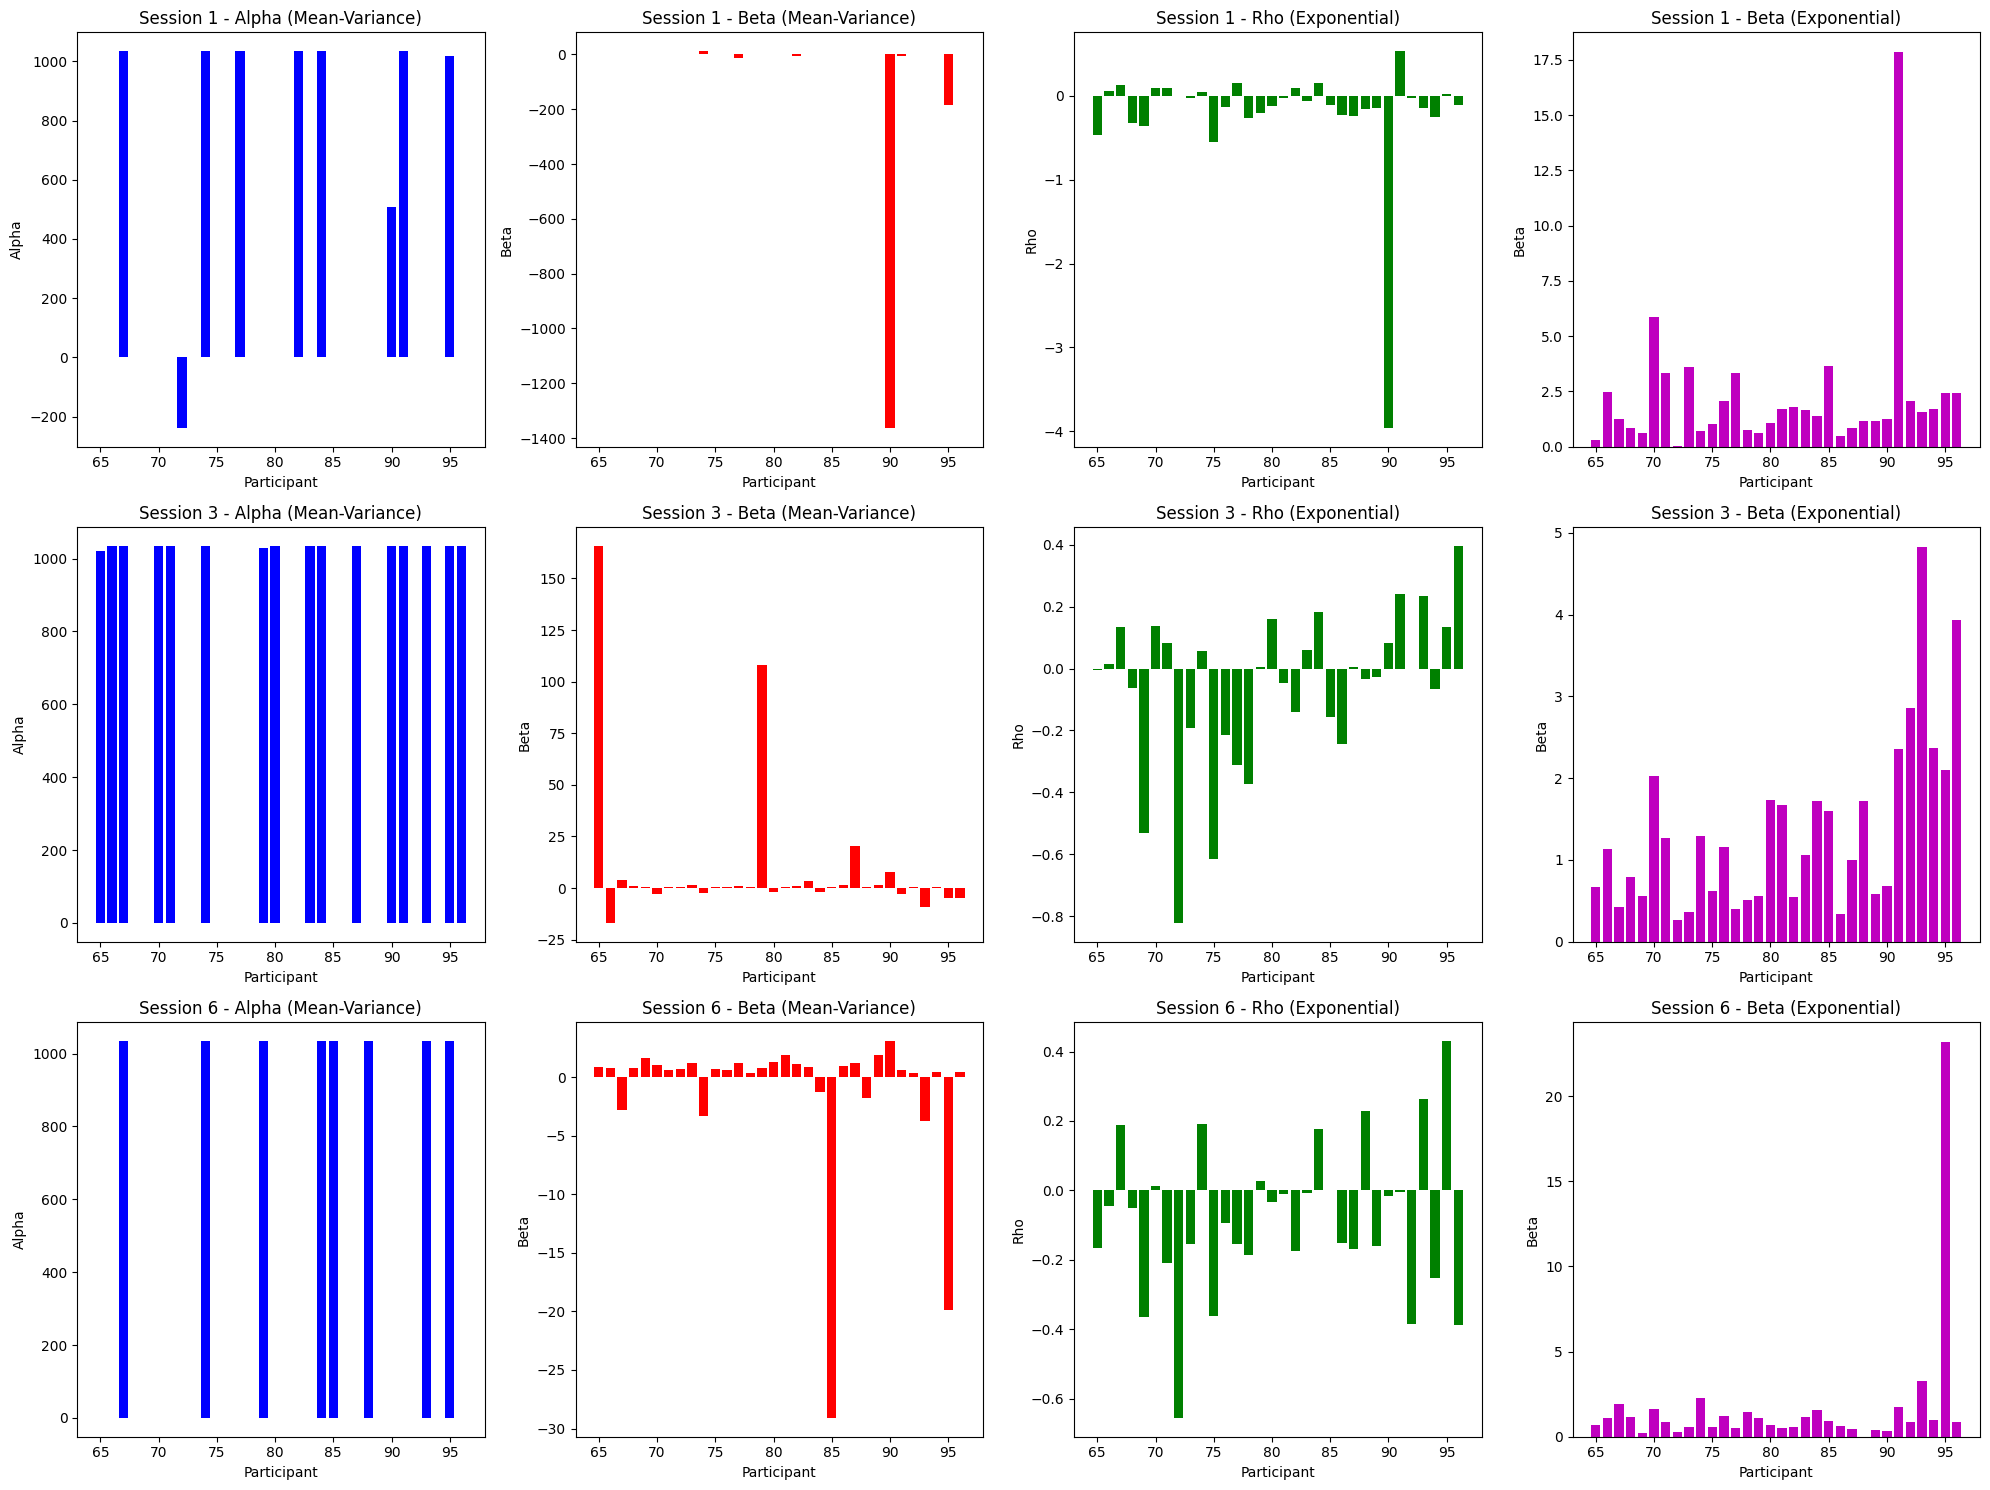

In [8]:
# Plotting the parameters for each participant and each session
participants = list(results.keys())
sessions = [1, 3, 6]

fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i, session in enumerate(sessions):
    alphas = [results[p][session]["Mean-Variance"]["alpha"] if session in results[p] else 0 for p in participants]
    betas_mv = [results[p][session]["Mean-Variance"]["beta"] if session in results[p] else 0 for p in participants]
    rhos = [np.log(results[p][session]["Exponential"]["rho"]) if session in results[p] else 0 for p in participants]
    betas_exp = [results[p][session]["Exponential"]["beta"] if session in results[p] else 0 for p in participants]

    # Bar plot for alpha
    axs[i, 0].bar(participants, alphas, color='b')
    axs[i, 0].set_title(f'Session {session} - Alpha (Mean-Variance)')
    axs[i, 0].set_xlabel('Participant')
    axs[i, 0].set_ylabel('Alpha')

    # Bar plot for beta (Mean-Variance)
    axs[i, 1].bar(participants, betas_mv, color='r')
    axs[i, 1].set_title(f'Session {session} - Beta (Mean-Variance)')
    axs[i, 1].set_xlabel('Participant')
    axs[i, 1].set_ylabel('Beta')

    # Bar plot for rho (Exponential)
    axs[i, 2].bar(participants, rhos, color='g')
    axs[i, 2].set_title(f'Session {session} - Rho (Exponential)')
    axs[i, 2].set_xlabel('Participant')
    axs[i, 2].set_ylabel('Rho')

    # Bar plot for beta (Exponential)
    axs[i, 3].bar(participants, betas_exp, color='m')
    axs[i, 3].set_title(f'Session {session} - Beta (Exponential)')
    axs[i, 3].set_xlabel('Participant')
    axs[i, 3].set_ylabel('Beta')

plt.tight_layout()
plt.show()


# Better Output Presentation (parameters per participant on all sessions)

In [9]:

# Data Preparation: Filter and Group by Participant
data_filtered = data[data["session"].isin([1, 3, 6])]
data_grouped = data_filtered.groupby("participant")
participant_data = {}

for participant, data_part in data_grouped:
    sessions = []
    for s in [1, 3, 6]:
        session_data = data_part[data_part["session"] == s]
        session_list = session_data[
            ["observee", "sure_gain", "risk_gain", "risk_prob", "chosen"]
        ].values
        sessions.append(session_list)
    participant_data[participant] = sessions

# Store results for each participant
results = {}

# Loop through each participant's data and fit the utility functions
for participant, sessions in participant_data.items():
    combined_data = np.vstack(sessions)
    sure_gain = combined_data[:, 1].astype(float)
    risk_gain = combined_data[:, 2].astype(float)
    risk_prob = combined_data[:, 3].astype(float)
    chosen = combined_data[:, 4].astype(int)

    # Fit Mean-Variance Utility Function
    initial_params_mv = [0, 1]
    result_mv = minimize(
        mean_variance_utility,
        initial_params_mv,
        args=(risk_gain, risk_prob, sure_gain, chosen),
        method="BFGS",
    )
    alpha_mv, beta_mv = result_mv.x

    # Fit Exponential Utility Function
    initial_params_exp = [1, 1]
    result_exp = minimize(
        exponential_utility,
        initial_params_exp,
        args=(risk_gain, risk_prob, sure_gain, chosen),
        method="BFGS",
    )
    rho_exp, beta_exp = result_exp.x

    # Store the results for this participant
    results[participant] = {
        "Mean-Variance": {"alpha": alpha_mv, "beta": beta_mv},
        "Exponential": {"rho": rho_exp, "beta": beta_exp},
    }

# Output the results for all participants
for participant, res in results.items():
    print(f"Participant {participant}:")
    print(
        f"  Mean-Variance Utility Function: alpha = {res['Mean-Variance']['alpha']:.4f}, beta = {res['Mean-Variance']['beta']:.4f}"
    )
    print(
        f"  Exponential Utility Function: rho = {np.log(res['Exponential']['rho']):.4f}, beta = {res['Exponential']['beta']:.4f}"
    )

<ipython-input-3-d8069b73868d>:10: RuntimeWarning: divide by zero encountered in log
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868d>:10: RuntimeWarning: invalid value encountered in multiply
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868d>:9: RuntimeWarning: overflow encountered in exp
  prob = 1 / (1 + np.exp(-logit))
<ipython-input-3-d8069b73868d>:10: RuntimeWarning: divide by zero encountered in log
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868d>:10: RuntimeWarning: invalid value encountered in multiply
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868d>:10: RuntimeWarning: divide by zero encountered in log
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868d>:10: RuntimeWarning: invalid value encountered in 

Participant 65:
  Mean-Variance Utility Function: alpha = -0.0104, beta = 0.6887
  Exponential Utility Function: rho = -0.2070, beta = 0.7365
Participant 66:
  Mean-Variance Utility Function: alpha = -0.0002, beta = 0.6841
  Exponential Utility Function: rho = 0.0035, beta = 1.4839
Participant 67:
  Mean-Variance Utility Function: alpha = 1034.2398, beta = 0.3979
  Exponential Utility Function: rho = 0.1458, beta = 1.2001
Participant 68:
  Mean-Variance Utility Function: alpha = -0.0078, beta = 0.6217
  Exponential Utility Function: rho = -0.1353, beta = 1.0627
Participant 69:
  Mean-Variance Utility Function: alpha = -0.0230, beta = 0.6413
  Exponential Utility Function: rho = -0.4152, beta = 0.4946
Participant 70:
  Mean-Variance Utility Function: alpha = 0.0000, beta = 1.0000
  Exponential Utility Function: rho = 0.0816, beta = 2.9758
Participant 71:
  Mean-Variance Utility Function: alpha = -0.0006, beta = 0.5480
  Exponential Utility Function: rho = -0.0136, beta = 1.7399
Particip

<ipython-input-3-d8069b73868d>:10: RuntimeWarning: divide by zero encountered in log
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868d>:10: RuntimeWarning: invalid value encountered in multiply
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868d>:9: RuntimeWarning: overflow encountered in exp
  prob = 1 / (1 + np.exp(-logit))
<ipython-input-3-d8069b73868d>:9: RuntimeWarning: overflow encountered in exp
  prob = 1 / (1 + np.exp(-logit))
<ipython-input-3-d8069b73868d>:10: RuntimeWarning: divide by zero encountered in log
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868d>:10: RuntimeWarning: invalid value encountered in multiply
  log_likelihood = chosen * np.log(prob) + (1 - chosen) * np.log(1 - prob)
<ipython-input-3-d8069b73868d>:10: RuntimeWarning: divide by zero encountered in log
  log_likelihood = chosen * np.log(prob) + 

# Plot

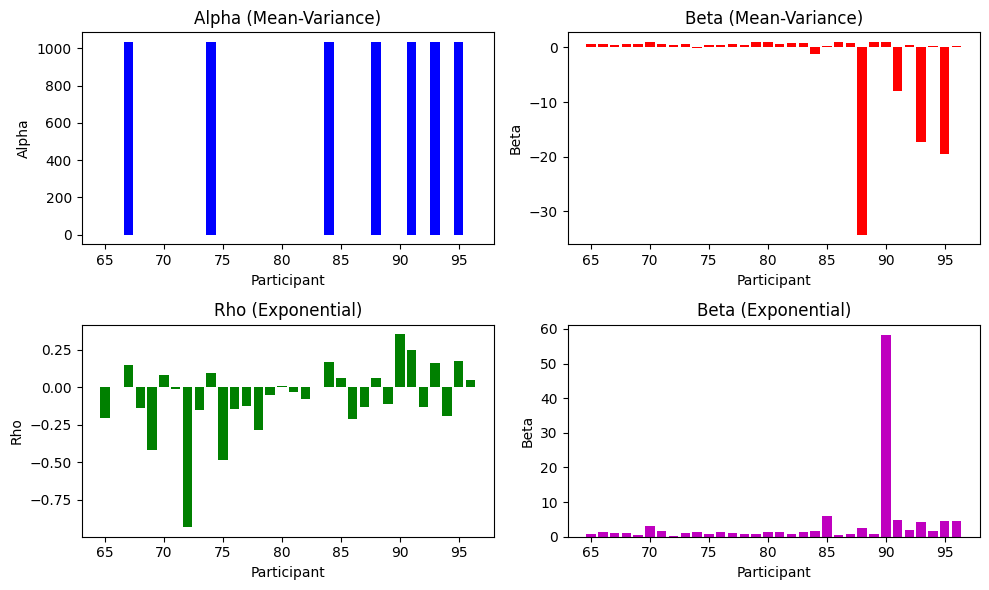

In [12]:
# Plotting the parameters for each participant
participants = list(results.keys())
alphas = [results[p]["Mean-Variance"]["alpha"] for p in participants]
betas_mv = [results[p]["Mean-Variance"]["beta"] for p in participants]
rhos = [np.log(results[p]["Exponential"]["rho"]) for p in participants]
betas_exp = [results[p]["Exponential"]["beta"] for p in participants]

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Bar plot for alpha
axs[0, 0].bar(participants, alphas, color='b')
axs[0, 0].set_title('Alpha (Mean-Variance)')
axs[0, 0].set_xlabel('Participant')
axs[0, 0].set_ylabel('Alpha')

# Bar plot for beta (Mean-Variance)
axs[0, 1].bar(participants, betas_mv, color='r')
axs[0, 1].set_title('Beta (Mean-Variance)')
axs[0, 1].set_xlabel('Participant')
axs[0, 1].set_ylabel('Beta')

# Bar plot for rho (Exponential)
axs[1, 0].bar(participants, rhos, color='g')
axs[1, 0].set_title('Rho (Exponential)')
axs[1, 0].set_xlabel('Participant')
axs[1, 0].set_ylabel('Rho')

# Bar plot for beta (Exponential)
axs[1, 1].bar(participants, betas_exp, color='m')
axs[1, 1].set_title('Beta (Exponential)')
axs[1, 1].set_xlabel('Participant')
axs[1, 1].set_ylabel('Beta')

plt.tight_layout()
plt.show()